<a href="https://colab.research.google.com/github/davidsjohnson/xai_ac_wise25/blob/main/notebooks/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI for Affective Computing (WiSe2025)
# Exercise 2: Local Explanations of Facial Expression Recognition with Action Units

In this notebook you will attempt to generate local explanations for predictions of tree-based models trained on Facial Action Units extracted from the AffectNet dataset, see Exercise 1 notebook for more details.  

We will use a variety of different methods to generate local explanations, including (but not limited to) [LIME](https://github.com/marcotcr/lime) and [SHAP](https://shap.readthedocs.io/en/latest/), two of the most common approaches used for local explanations on tabular data.  

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.


**NOTE**: If using Google Colab, you can use a CPU only runtime as the model is not optimized for GPU acceleration.

## Notebook Setup

Make sure to set the `colab` flag when using Google Colab so all necessary packages and paths are setup properly.

If not using Colab, make sure to update the required packages by running `pip install -r requirements` in local virtual environment.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
if IN_COLAB:
  print("Running on Google Colab and installing dependencies")
  !git clone https://github.com/davidsjohnson/xai_ac_wise25.git
  # fix xgboost incompatiblity issue
  %pip uninstall -y -q scikit-learn
  %pip install -q scikit-learn==1.5.2
  %pip install -q interpret
  %pip install -q lime
  %pip install -q shap

In [3]:
import sys
import os

if IN_COLAB:
  sys.path.append(os.path.realpath('xai_ac_wise25'))
else:  
  sys.path.append(os.path.realpath('../'))

In [4]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io

import utils
import img_utils

In [5]:
base_dir = Path('../data/') if not IN_COLAB else Path('wise25_xai_ac/data/')

In [6]:
# download the AffectNet dataset extracted features and a sample set of images for visualization
affnet_dir = utils.download_file('https://uni-bielefeld.sciebo.de/s/EmfF9r93LG4jcT9/download',
                          file_name='affectnet_data.zip',
                          cache_dir=base_dir,
                          extract=True,
                          force_download=False,     # set to False if you have already downloaded the dataset
                          archive_folder='affectnet_data')
affnet_dir

File downloaded to: ../data/affectnet_data.zip


PosixPath('../data/affectnet_data')

## Data Loading

### Loading Images and Action Units

In the next cell, you will load csv files that contain extracted actions units and paths to the corresponding images.  

In [7]:

# Full data from training and evaluation
train_csv = affnet_dir / 'affectnet_aus/train_aus.csv'
val_csv = affnet_dir / 'affectnet_aus/val_aus.csv'

# load training and validation data as pandas dataframes
# action units extracted from the AffectNet dataset via OpenFace
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)

# smaller dataset for explanations
xai_csv = affnet_dir / 'affectnet_aus/eval_aus.csv'
df_xai = pd.read_csv(xai_csv)
df_xai['image'] = df_xai['image'].str.replace('../data', str(affnet_dir))

# get the class labels
class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # same class labels as before

# Gets all images from folder used for XAI tasks
images = [io.imread(f) for f in df_xai.image]

Here is a feature name map to make AUs values easier to Read in Shap Plots

In [8]:
# Mapping of Action Units (AUs) to their names
AU_MAP = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip Stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips Part",
    "AU26": "Jaw Drop",
    "AU28": "Lip Suck",
    "AU45": "Blink",
}

# Generate mappings for both 'r' (regression) and 'c' (classification) versions
AU_FEATURE_MAP = {f"{au}_r": f"{au} - {name} - R" for au, name in AU_MAP.items()}
AU_FEATURE_MAP.update({f"{au}_c": f"{au} - {name} - C" for au, name in AU_MAP.items()})

# Print the mapping
print(AU_FEATURE_MAP)

{'AU01_r': 'AU01 - Inner Brow Raiser - R', 'AU02_r': 'AU02 - Outer Brow Raiser - R', 'AU04_r': 'AU04 - Brow Lowerer - R', 'AU05_r': 'AU05 - Upper Lid Raiser - R', 'AU06_r': 'AU06 - Cheek Raiser - R', 'AU07_r': 'AU07 - Lid Tightener - R', 'AU09_r': 'AU09 - Nose Wrinkler - R', 'AU10_r': 'AU10 - Upper Lip Raiser - R', 'AU12_r': 'AU12 - Lip Corner Puller - R', 'AU14_r': 'AU14 - Dimpler - R', 'AU15_r': 'AU15 - Lip Corner Depressor - R', 'AU17_r': 'AU17 - Chin Raiser - R', 'AU20_r': 'AU20 - Lip Stretcher - R', 'AU23_r': 'AU23 - Lip Tightener - R', 'AU25_r': 'AU25 - Lips Part - R', 'AU26_r': 'AU26 - Jaw Drop - R', 'AU28_r': 'AU28 - Lip Suck - R', 'AU45_r': 'AU45 - Blink - R', 'AU01_c': 'AU01 - Inner Brow Raiser - C', 'AU02_c': 'AU02 - Outer Brow Raiser - C', 'AU04_c': 'AU04 - Brow Lowerer - C', 'AU05_c': 'AU05 - Upper Lid Raiser - C', 'AU06_c': 'AU06 - Cheek Raiser - C', 'AU07_c': 'AU07 - Lid Tightener - C', 'AU09_c': 'AU09 - Nose Wrinkler - C', 'AU10_c': 'AU10 - Upper Lip Raiser - C', 'AU12_

In [9]:
# update the feature names in the dataframe to be more descriptive
df_train.rename(columns=AU_FEATURE_MAP, inplace=True)
df_val.rename(columns=AU_FEATURE_MAP, inplace=True)
df_xai.rename(columns=AU_FEATURE_MAP, inplace=True)

In [10]:
# get only the columns storing action units from the dataframe
# there are also facial landmarks and other features in the dataset could be useful
# but we igore them for now and focus on action units
feature_names = [col for col in df_val.columns if col.startswith('AU')]
numerical_features = [feat for feat in feature_names if '- R' in feat]
numerical_idxs = [i for i, feat in enumerate(feature_names) if '- R' in feat]
categorical_features = [feat for feat in feature_names if '- C' in feat]
categorical_idxs = [i for i, feat in enumerate(feature_names) if '- C' in feat]

## Model Training and Evaluation

First, let's load the data and the trained models. Then we will evaluate the model peformance, before we start with the explanations.

In [11]:
from xgboost import XGBClassifier

### Setup the Datasets

In [12]:
# we will only use numerical features to remove collinearity with categorical features
X_train = df_train[numerical_features]
y_train = df_train['class']
X_test = df_val[numerical_features]
y_test = df_val['class']

X_xai = df_xai[numerical_features]
y_xai = df_xai['class']

print('Training data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)
print('XAI data shape:', X_xai.shape, y_xai.shape)

Training data shape: (36685, 17) (36685,)
Test data shape: (3908, 17) (3908,)
XAI data shape: (80, 17) (80,)


### Train the Model

Now let's train the XGBoost Model on the split dataset. The accuracy of the model in the training data should be around $92\%$

In [13]:
# # Train model from scratch
random_state = 10
clf = XGBClassifier(max_depth=20, eta=0.1, reg_lambda=3, random_state=random_state)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9962382445141066

### Evaluate the Model

Now we will evaluate it on the test dataset. Unfortunately, the accuracy is only $40\%$ but this is still well above chance guessing which would be $1 / 8 * 100 = 12.5\%$ accuracy (since there are 8 total classes)

In [14]:
# get model predictions
y_test_preds = clf.predict(X_test)
y_test_true = y_test

# eval results
print(classification_report(y_test_true, y_test_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.30      0.41      0.35       485
       Happy       0.55      0.65      0.59       488
         Sad       0.37      0.37      0.37       490
    Surprise       0.37      0.34      0.35       488
        Fear       0.43      0.43      0.43       487
     Disgust       0.49      0.34      0.40       493
       Anger       0.36      0.39      0.37       482
    Contempt       0.38      0.25      0.30       495

    accuracy                           0.40      3908
   macro avg       0.40      0.40      0.40      3908
weighted avg       0.40      0.40      0.40      3908



### Setup XAI dataset and Predictions

Evaluate the model and get predictions for the XAI subset 

In [15]:
# Evaluate model on XAI data
y_xai_preds = clf.predict(X_xai)
y_xai_true = y_xai

df_xai['xgb_pred'] = y_xai_preds

print(classification_report(y_xai_true, y_xai_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.24      0.40      0.30        10
       Happy       0.64      0.70      0.67        10
         Sad       0.50      0.60      0.55        10
    Surprise       0.38      0.30      0.33        10
        Fear       0.62      0.50      0.56        10
     Disgust       0.50      0.40      0.44        10
       Anger       0.18      0.20      0.19        10
    Contempt       0.60      0.30      0.40        10

    accuracy                           0.42        80
   macro avg       0.46      0.42      0.43        80
weighted avg       0.46      0.42      0.43        80



**Preview the Dataset with Predictions**

The code below will display images from the XAI dataset.
- Try changing value of `start` to get a new set of images (there are 10 images for each class; for example, the class happy will be at indexes 10-19)
- Search through the images to find some that might be interesting to Explain

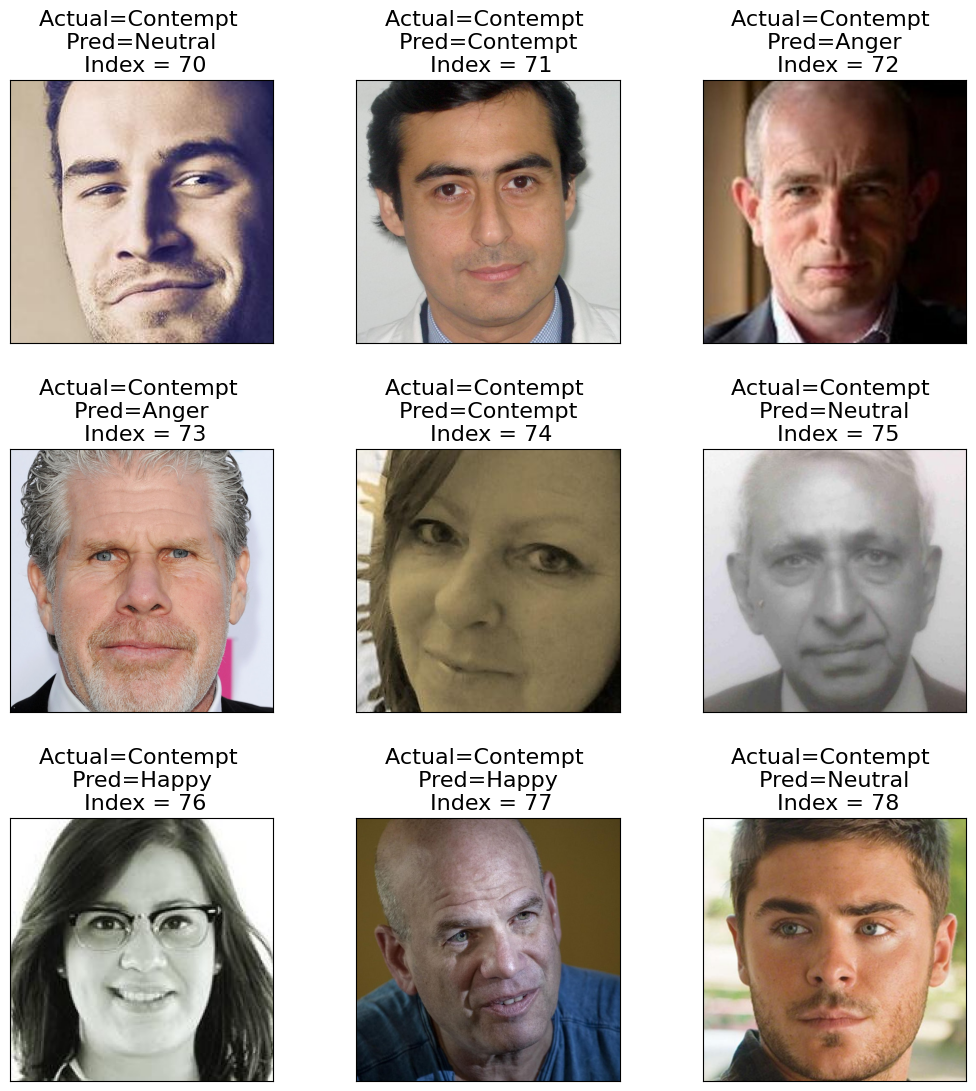

In [16]:
start=70
img_utils.display_nine_images(images, df_xai['class'], df_xai['xgb_pred'], start)

## Main Tasks A: Generate Local Explanations

Following the methods we used in the last exercise, we will now generate local explanation for individual predications


### Task 1: Generate Explanations from an Interpretable Model

In this task, you will generate and review local explanations using the interpretable model from Exercise 1, [an Explainable Boosting Machine (EBM)](https://interpret.ml/docs/ebm.html). The code for training the model is already provided so you will only need to generate the local explanations. 

1. First, select 6 images from the XAI dataset above, 3 correctly predicted images and 3 incorrect.
   - (store the image indexes, as you will use these in the upcoming tasks as well)
2. Use the built-in functionality from the EBM to show the local explanations for the 6 images.
3. Answer the questions below.

In [17]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show 

In [18]:
ebm = ExplainableBoostingClassifier(reg_lambda=3)
ebm.fit(X_train, y_train)
ebm.score(X_train, y_train)

/home/flo/.conda/envs/xai_ac/lib/python3.12/site-packages/interpret/glassbox/_ebm/_ebm.py:1250: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


0.43227477170505657

In [22]:
# get model predictions
y_test_preds = ebm.predict(X_test)
y_test_true = y_test

# eval results
print(classification_report(y_test_true, y_test_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.31      0.38      0.34       485
       Happy       0.58      0.67      0.62       488
         Sad       0.33      0.33      0.33       490
    Surprise       0.37      0.34      0.35       488
        Fear       0.42      0.41      0.42       487
     Disgust       0.43      0.31      0.36       493
       Anger       0.32      0.38      0.35       482
    Contempt       0.37      0.30      0.33       495

    accuracy                           0.39      3908
   macro avg       0.39      0.39      0.39      3908
weighted avg       0.39      0.39      0.39      3908



In [ ]:
##### Your Code Here #####
##########################

#### Task 1 Questions

1. How are the local explanations generated from the EBM? What makes this method inherently interpretable?
2. How are the local explanation plots interpreted?

### Task 2: Generate individual conditional expectation (ICE) plots

Individual conditional expectation (ICE) plots are similar to PDP, but show how an individual instance's prediction changes when a feature changes. See https://christophm.github.io/interpretable-ml-book/ice.html for a more indepth description.

In this task, you will create ICEs for the XGB model using the Scikit-Learn via the PDP implementation: https://scikit-learn.org/stable/modules/partial_dependence.html.


1. Using the same emotion classes and features combinations from Exercise 1, generate ICEs using the XAI data subset. You can also include the PDP in the visualization. 
2. Then answer the questions below.

In [20]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
##### Your Code Here #####
##########################

#### Task 2 Questions

1. What do the individual ICE lines represent? And how do they relate the the PDP?
2. What do the explanations tell you about each feature?  
3. Do the explanations alighn with the expected AUs explained on the iMotions website regarding "Emotions and Action Units"?

## Main Tasks B: Generate Explanations with LIME

Local Interpretable Model-agnostic Explanations (LIME) is a widely used method for generating local explanations by learning an interpretable model in the vicinity of a specific instance. It does so by perturbing the instance to create a neighborhood of similar samples, which are then used to train the local surrogate model. You can read more about it in the original paper: [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://dl.acm.org/doi/10.1145/2939672.2939778) by Ribeiro et al. (2016).

In [23]:
import lime
from lime.lime_tabular import LimeTabularExplainer

### Task 3: Generate Local LIME Explanations

In this task you will use the [LIME Python package](https://github.com/marcotcr/lime) to generate explanations on the AffectNet dataset.  

1. First implement a [LimeTabularExplainer](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular), you can review the [LIME tutorial](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html) for help.
2. Generate LIME explanations for your 6 selected data instances, using the `LimeTabularExplainer` and plot the explanations for each data instance (see tutorial mentioned above).  
    - HINT: Before showing an explanation, plot the image using `utils.display_one_image()` utility function.  Use `plt.show()` immediately after calling `utils.display_one_image()` to display the image before the explanation charts.
    - Make sure to print out the **True** and **Predicted** labels for each instance.
    - Try experimenting with different parameters for the explainer and explanation.
3. Answer the questions below

In [ ]:
##### Your Code Here #####
##########################


#### Task Questions

1. Explain in more detail how LIME generates the local neighborhood and how this is used to create a local model used for explanations.  
2. What do the generated explanations reveal about the models predictions? Do they align with the expected action units for the given emotion (see "Emotions and Action Units": https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/)?
3. In your opinion, how understandable are the explanations? Why?

Your answers here...

## Main Tasks C: Generate Explanations with SHAP

SHAP (SHapley Additive exPlanations) is a popular method for generating local explanations by assigning each feature a contribution value based on Shapley values from game theory. It explains a model’s prediction by considering all possible combinations of feature contributions. We've already read about the SHAP Tree Explainer; you can also read more about SHAP in the original paper that provides a more generalized description of the method: [“A Unified Approach to Interpreting Model Predictions”](https://arxiv.org/abs/1705.07874) by Lundberg and Lee (2017).

In this task you will generate both global and local explanations for the XGBoost model using SHAP. Review the [SHAP Documentation for Details](https://shap.readthedocs.io/en/latest/index.html)

In [21]:
import shap

### Task 4 - Generate Local SHAP Explanations

First, generate local explanations, as they from the basis of the global explanations.

1. Generatel local explanations for each of your six images using a Waterfall plot. 
    - For each incorrect image, make sure to plot both the explanation for the prediction and the true emotion. 
    - When displaying SHAP plot, also show the original image along side it
2.  Generate local explanations using another type of plot from the SHAP library.
3. Answer the questions below

In [ ]:
##### Your Code Here #####
##########################

#### Task Questions

1. Which plot type (the Waterfall or your selected one) is more intuitive to you and why?
2. How should you interpret the SHAP values presented in the explanations?


Your answers here...

### Task 5 - Generate Global SHAP Explanations

Now, in this task you will generate Global SHAP Explanations using the `X_xai` data subset.

1. Generate explanations using the `X_xai` dataset and then plot the global explanations for each class of the AffectNet dataset using a `summary_plot` (which should be the same as the `beeswarm_plot`). 
    - The XGBoost tutorial in the SHAP documentation is a good place get started.  Keep in mind that Facial Expression Recognition is a multi class (8 emotion) problem rather than a binary problem as in the tutorial.
2. Then review the [documentation for the different plot types available](https://shap.readthedocs.io/en/latest/api.html#plots), and generate class level explanations using at least one other global explanation type.
3. Answer the questions below

In [ ]:
###### Enter your Code Here ######
##################################

#### Task Questions

1. How do you interpret the summary plot (ie beeswarm plot) for local explanations?  How do you interpret the plot of your choosing?
1. How do you interpret the beeswarm plot (ie beeswarm plot)?  How do you interpret the global explanation plot of your choosing?
2. How do SHAP global explanations compare to the methods from Exercise 1?

Your answers here...

### Final Questions

1. Of the local explanation types, which method did you find the most interpretable?  Why?
2. Do the explanations for each of the local approaches align for the same prediction? What does this tell us about the methods? How do you interpret these differences?
3. In general, do you find that the model predictions align with the expected AUs for the ground truth and predicted emotions?


Your answers here...